# Load the models

In [ ]:
# import the models
from cobra.io import load_json_model
ecoli = load_json_model("ecoli.json")
pf = load_json_model("pf.json")
# print(ecoli.optimize())
# print(pf.optimize())
    
# load peripheral packages
import warnings
warnings.filterwarnings(action='once')
from pandas import set_option
set_option("display.max_rows", None)
from time import process_time

In [2]:
for ex in ecoli.exchanges:
    print(ex.bounds)
    print(dir(ex))
    break

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


(-100.0, 100.0)
['__add__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__isub__', '__le__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__weakref__', '_annotation', '_associate_gene', '_check_bounds', '_dissociate_gene', '_genes', '_gpr', '_id', '_lower_bound', '_metabolites', '_model', '_repr_html_', '_set_id_with_model', '_update_awareness', '_upper_bound', 'add_metabolites', 'annotation', 'boundary', 'bounds', 'build_reaction_from_string', 'build_reaction_string', 'check_mass_balance', 'compartments', 'copy', 'delete', 'flux', 'flux_expression', 'forward_variable', 'functional', 'gene_name_reaction_rule', 'gene_reaction_rule', 'genes', '

# Load the conditions

In [2]:
# Define the standard graphs from each simulation
graphs_list = [
    {
        'trial':'G48',
        "phenotype": '*',
        'content': 'biomass',
        'experimental_data': False,
        # "parsed":True
    },
    {
        'trial':'G48',
        'content': "conc",
    },
    {
        'trial':'G48',
        "phenotype": '*',
        'content': 'biomass',
        "parsed": True
    },
    {
        'trial':'G48',
        'content': 'total_biomass',
        'experimental_data': True
    }
]

def update_graphs(trial):
    graphs = graphs_list.copy()
    for graph in graphs:
        graph["trial"] = trial
    return graphs

In [3]:
species_abundances = {
    1:{"ecoli":0, "pf":1},
    2:{"ecoli":1, "pf":50},
    3:{"ecoli":1, "pf":20},
    4:{"ecoli":1, "pf":10},
    5:{"ecoli":1, "pf":3},
    6:{"ecoli":1, "pf":1},
    7:{"ecoli":3, "pf":1},
    8:{"ecoli":10, "pf":1},
    9:{"ecoli":20, "pf":1},
    10:{"ecoli":1, "pf":0},
    11:{"ecoli":0, "pf":0}
}
carbon_conc_series = {'rows': {
    'cpd00136': {'B':0, 'C': 0, 'D': 1, 'E': 1, 'F': 4, 'G': 4},
    'cpd00179': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
    'cpd00100': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
}}
species_identities_rows = {
    1:{"ecoli":"mRuby"},
    2:{"ecoli":"ACS"},
    3:{"ecoli":"mRuby"},
    4:{"ecoli":"ACS"},
    5:{"ecoli":"mRuby"},
    6:{"ecoli":"ACS"}
}

# Simulate

## Parameterize the data

In [6]:
%%time 

%run ../../../ModelSEED/ModelSEEDpy/modelseedpy/community/mscommphitting.py

def _partition_coefs(initial_val, divisor):
    return (initial_val, initial_val/divisor, initial_val/divisor**2, initial_val/divisor**3, initial_val/divisor**4)

test_com = MSCommPhitting('../../../ModelSEED/ModelSEEDDatabase',
                           community_members = {
                                ecoli: {
                                    'name': 'ecoli', 
                                    'phenotypes': {
                                        'Maltose': {"consumed":["cpd00179"],
                                                 "excreted":["cpd00029"]}, #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                                        'Acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                                        }
                                },
                                pf: {
                                    'name': 'pf',
                                    'phenotypes': {
                                        'Acetate': {"consumed":["cpd00029"]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                                        '4-Hydroxybenzoate': {"consumed":["cpd00136"]}, # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                                        'Glycerol': {"consumed":["cpd00100"],
                                                 "excreted":["cpd00266"]}, #kbase_api.get_from_ws('93465/13/1'), 
                                        }
                                }
                            },
                            data_paths = {'path':"data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx", 'Raw OD(590)':'OD', 'mNeonGreen':'pf', 'mRuby':'ecoli'},
                            species_abundances = species_abundances,
                            carbon_conc = carbon_conc_series,
                            ignore_trials = {'rows': ['C', 'D', 'E', 'F', 'G'], 'columns': [1,2,3,4,5,6,7,8,9,10,12]},
                            species_identities_rows = species_identities_rows)

test_com.fit_kcat(parameters = {'cvmin': 1e-2, 'bcv': 1e-4, "stationary": 1e1}, 
                  rel_final_conc = {"cpd00179":0.1},
                  zero_start = ["cpd00029"],
                  abs_final_conc = {"cpd00029":0}, # metabolomics data
                  graphs=update_graphs("G10"),
                  export_zip_name = 'maltose_ecoli_test.zip',
                  export_lp = "maltose_ecoli_test.lp",
                  primals_export_path="maltose_ecoli_primals_test.json")


 GCF_000005845.2.RAST.mdl
EX_cpd00179_e0
EX_cpd00029_e0

 GCF_001612705.1.RAST.mdl
EX_cpd00029_e0
EX_cpd00136_e0


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


EX_cpd00100_e0
The ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B12', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12'] trials were dropped from the OD measurements per the ignore_trials parameter.
The [81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166] timesteps (with [1.11135657 1.11403494 1.10087516 1.1021111  1.14037094 1.13783

ecoli_Maltose  ecoli_Acetate    pf_Acetate  \
rxn                                                          
EX_cpd00001_e0   1.618125e+01   4.544367e+01  4.533296e+01   
EX_cpd00007_e0  -6.452599e+00  -2.035609e+01 -2.025521e+01   
EX_cpd00009_e0  -7.625410e-01  -7.625410e-01 -7.625410e-01   
EX_cpd00011_e0   1.073081e+00   2.388151e+01  2.377641e+01   
EX_cpd00013_e0  -8.611666e+00  -8.611666e+00 -8.611666e+00   
EX_cpd00029_e0   1.051566e+01  -3.069851e+01 -3.063614e+01   
EX_cpd00030_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00034_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00047_e0   1.781127e+01   0.000000e+00  0.000000e+00   
EX_cpd00048_e0  -2.263972e-01  -2.263972e-01 -2.263972e-01   
EX_cpd00058_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00063_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00067_e0   3.485430e+01  -2.417395e+01 -2.411719e+01   
EX_cpd00099_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00100_e0   0.000000e+00   0.000000e+00  0.000000e+00   
EX_cpd00116_e0   2.806159e-03   2.806159e-03  2.806159e-03   
EX_cpd00136_e0   0.000000e+00   0.000000e+00  0.000000e+00   
EX_cpd00142_e0  -2.155574e-12   0.000000e+00  0.000000e+00   
EX_cpd00149_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00179_e0  -6.452599e+00   0.000000e+00  0.000000e+00   
EX_cpd00205_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00254_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00609_e0   1.080143e-15   0.000000e+00  0.000000e+00   
EX_cpd00751_e0   5.380949e-29   0.000000e+00  0.000000e+00   
EX_cpd01914_e0   1.315265e-12   0.000000e+00  0.000000e+00   
EX_cpd03048_e0   6.972492e-13   0.000000e+00  0.000000e+00   
EX_cpd10515_e0  -8.418477e-03  -1.122464e-02 -1.122464e-02   
EX_cpd10516_e0  -2.806159e-03  -1.359101e-11  4.321634e-12   
EX_cpd15378_e0   2.806159e-03   2.806159e-03  0.000000e+00   
bio              1.000000e+00   1.000000e+00  1.000000e+00   

                pf_4~Hydroxybenzoate  pf_Glycerol  
rxn                                                
EX_cpd00001_e0          2.449548e+01    44.826581  
EX_cpd00007_e0         -5.333079e+01   -12.153085  
EX_cpd00009_e0         -7.625410e-01    -0.762541  
EX_cpd00011_e0          5.685199e+01     8.078550  
EX_cpd00013_e0         -8.611666e+00    -8.611666  
EX_cpd00029_e0          0.000000e+00     0.000000  
EX_cpd00030_e0         -2.806159e-03    -0.002806  
EX_cpd00034_e0         -2.806159e-03    -0.002806  
EX_cpd00047_e0          0.000000e+00     0.000000  
EX_cpd00048_e0         -2.263972e-01    -0.226397  
EX_cpd00058_e0         -2.806159e-03    -0.002806  
EX_cpd00063_e0         -2.806159e-03    -0.002806  
EX_cpd00067_e0         -2.043758e+01     6.518956  
EX_cpd00099_e0         -2.806159e-03    -0.002806  
EX_cpd00100_e0          0.000000e+00   -15.191477  
EX_cpd00116_e0          2.806159e-03     0.002806  
EX_cpd00136_e0         -1.347827e+01     0.000000  
EX_cpd00142_e0          0.000000e+00     0.000000  
EX_cpd00149_e0         -2.806159e-03    -0.002806  
EX_cpd00179_e0          0.000000e+00     0.000000  
EX_cpd00205_e0         -2.806159e-03    -0.002806  
EX_cpd00254_e0         -2.806159e-03    -0.002806  
EX_cpd00609_e0          0.000000e+00     0.000000  
EX_cpd00751_e0          0.000000e+00     0.000000  
EX_cpd01914_e0          0.000000e+00     0.000000  
EX_cpd03048_e0          0.000000e+00     0.000000  
EX_cpd10515_e0         -1.122464e-02    -0.011225  
EX_cpd10516_e0         -3.288257e-13     0.000000  
EX_cpd15378_e0          0.000000e+00     0.000000  
bio                     1.000000e+00     1.000000

KeyError: 'EX_cpd00266_e0'

### A bioproduction phenotype

In [7]:
# checking if the metabolite of interest is in the P.fluorescens  model

exists = "false"
for ex in pf.exchanges:
    if ex.id == "EX_cpd00480_c0":
        exists = "true"
print(exists)

false


In [8]:
exists = "false"
for met in ecoli.metabolites:
    if met.id == "cpd00480_c0":
        exists = "true"
print(exists)

true


In [19]:
for ex in ecoli.exchanges:
    print(ex.reaction)

cpd00067_e0 <=> 
cpd00182_e0 --> 
cpd00106_e0 --> 
cpd00075_e0 --> 
cpd00064_e0 --> 
cpd00108_e0 --> 
cpd00036_e0 --> 
cpd11576_e0 --> 
cpd04097_e0 --> 
cpd00154_e0 --> 
cpd00033_e0 --> 
cpd00412_e0 --> 
cpd00012_e0 --> 
cpd00118_e0 --> 
cpd01030_e0 --> 
cpd00161_e0 --> 
cpd00129_e0 --> 
cpd00971_e0 <=> 
cpd01012_e0 --> 
cpd00635_e0 --> 
cpd00039_e0 --> 
cpd01155_e0 --> 
cpd00246_e0 --> 
cpd01055_e0 --> 
cpd00020_e0 --> 
cpd00276_e0 --> 
cpd00082_e0 --> 
cpd00080_e0 --> 
cpd00023_e0 --> 
cpd15560_e0 --> 
cpd15561_e0 --> 
cpd00367_e0 --> 
cpd00063_e0 <=> 
cpd00058_e0 <=> 
cpd00107_e0 --> 
cpd00573_e0 --> 
cpd00184_e0 --> 
cpd00224_e0 --> 
cpd00314_e0 --> 
cpd01017_e0 --> 
cpd00222_e0 --> 
cpd00013_e0 <=> 
cpd01217_e0 --> 
cpd00051_e0 --> 
cpd00244_e0 <=> 
cpd11578_e0 --> 
cpd00179_e0 <=> 
cpd00205_e0 <=> 
cpd00355_e0 --> 
cpd00100_e0 --> 
cpd00009_e0 <=> 
cpd00281_e0 --> 
cpd00079_e0 --> 
cpd00060_e0 --> 
cpd00438_e0 --> 
cpd00034_e0 <=> 
cpd10516_e0 <=> 
cpd00249_e0 --> 
cpd00214_e0 --

In [29]:
o2_met = ecoli.metabolites.get_by_id("cpd00007_c0")
for rxn in o2_met.reactions:
    print(rxn.reaction)

cpd00001_c0 + cpd00007_c0 + cpd00493_c0 --> cpd00013_c0 + cpd00016_c0 + cpd00025_c0
cpd00007_c0 + cpd00041_c0 --> cpd00025_c0 + cpd00067_c0 + cpd03470_c0
cpd00007_c0 + cpd01270_c0 + cpd08023_c0 --> cpd00001_c0 + cpd00050_c0 + cpd00055_c0 + cpd00067_c0 + cpd00081_c0
cpd00001_c0 + cpd00007_c0 + cpd01298_c0 --> cpd00013_c0 + cpd00025_c0 + cpd00428_c0
cpd00007_c0 + 4 cpd00067_c0 + 4 cpd10515_c0 --> 2 cpd00001_c0 + 4 cpd10516_c0
cpd00007_c0 + 2 cpd00067_c0 + cpd02083_c0 --> 2 cpd00001_c0 + 2 cpd00011_c0 + cpd00791_c0
cpd00007_c0 + cpd17456_c0 --> cpd00067_c0 + cpd32206_c0
3 cpd00007_c0 + cpd00791_c0 --> 3 cpd00025_c0 + cpd01476_c0
cpd00005_c0 + 2 cpd00007_c0 + 2 cpd00418_c0 --> cpd00006_c0 + cpd00067_c0 + 2 cpd00209_c0
cpd00007_c0 + cpd00130_c0 --> cpd00025_c0 + cpd00032_c0
cpd00004_c0 + 2 cpd00007_c0 + 2 cpd00418_c0 --> cpd00003_c0 + cpd00067_c0 + 2 cpd00209_c0
0.5 cpd00007_c0 + 2 cpd00067_c0 + cpd15499_c0 --> cpd00001_c0 + 2 cpd00067_e0 + cpd15500_c0
2.0 cpd00067_c0 + 2.0 cpd00532_c0 <-- 

In [10]:
cyto_met = ecoli.metabolites.get_by_id("cpd00480_c0")
ex_met = cyto_met.copy()
ex_met.id = "cpd00480_e0"
ex_met.compartment = "e0"
print(ex_met.id, ex_met.compartment, dir(ex_met))

cpd00480_e0 e0 ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_annotation', '_bound', '_id', '_model', '_reaction', '_repr_html_', '_set_id_with_model', 'annotation', 'charge', 'compartment', 'constraint', 'copy', 'elements', 'formula', 'formula_weight', 'id', 'model', 'name', 'notes', 'reactions', 'remove_from_model', 'shadow_price', 'summary', 'y']


In [11]:
from cobra import Reaction

cpd00480_tr = Reaction("cpd00480_tr")
cpd00480_tr.name = "cpd00480 Transport"
cpd00480_tr.add_metabolites({
    ex_met: -1, cyto_met: 1
})
print(cpd00480_tr.reaction)

cpd00480_e0 --> cpd00480_c0


In [12]:
ecoli.add_metabolites([ex_met])
ecoli.add_boundary(ex_met, type="exchange")
pf.add_metabolites([ex_met])
pf.add_boundary(ex_met, type="exchange")

<Reaction EX_cpd00480_e0 at 0x1c2136dc9d0>

In [13]:
%%time 

%run data/standardized_data/datastandardization.py
growth_data_path="data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx"
experimental_metadata, growth_df, fluxes_df, standardized_carbon_conc, requisite_biomass, trial_name_conversion, data_timestep_hr, simulation_timestep, media_conc = GrowthData.process(
    community_members = {
        ecoli: {
            'name': 'ecoli', 
            'phenotypes': {
                'Maltose': {"consumed":["cpd00179"],
                         "excreted":["cpd00029"]}, #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                'Acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                # "2-Dehydro-D-gluconate": {"consumed":["cpd00480"]}
                }
        },
        pf: {
            'name': 'pf',
            'phenotypes': {
                #'Acetate': {"consumed":["cpd00029"], # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                #'4-Hydroxybenzoate': {"consumed":["cpd00136"]} # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                'D-Glucose': {"consumed":["cpd00027"],
                        "excreted":["cpd00480"]},
                }
        }
    },
    data_paths = {'path':growth_data_path, 'Raw OD(590)':'OD', 'mNeonGreen':'pf', 'mRuby':'ecoli'},
    species_abundances = species_abundances,
    carbon_conc_series = carbon_conc_series,
    ignore_trials = {'rows': ['C', 'D', 'E', 'F', 'G'], 'columns': [1,2,3,4,5,6,8,9,10,11,12]},
    species_identities_rows = species_identities_rows
)


 GCF_000005845.2.RAST.mdl

 GCF_001612705.1.RAST.mdl
The ['B2', 'B3', 'B4', 'B5', 'B6', 'B8', 'B9', 'B10', 'B11', 'B12', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12'] trials were dropped from the OD measurements per the ignore_trials parameter.
The [97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166] timesteps (with [1.12550559 1.12537038 1.12105398 1.11597471 1.11273534 1.12893569
 1.13334937 1.133368

In [14]:
requisite_biomass

{'G6': {'ecoli|mRuby': rxn
  EX_cpd00001_e0    11.704799
  EX_cpd00007_e0    -4.500000
  EX_cpd00009_e0    -0.531791
  EX_cpd00011_e0     1.168465
  EX_cpd00013_e0    -6.005719
  EX_cpd00029_e0     7.543605
  EX_cpd00030_e0    -0.001957
  EX_cpd00034_e0    -0.001957
  EX_cpd00047_e0    11.581247
  EX_cpd00048_e0    -0.157888
  EX_cpd00058_e0    -0.001957
  EX_cpd00063_e0    -0.001957
  EX_cpd00067_e0    23.677000
  EX_cpd00099_e0    -0.001957
  EX_cpd00116_e0     0.001957
  EX_cpd00149_e0    -0.001957
  EX_cpd00179_e0    -4.500000
  EX_cpd00205_e0    -0.001957
  EX_cpd00254_e0    -0.001957
  EX_cpd10515_e0    -0.005871
  EX_cpd10516_e0    -0.001957
  EX_cpd15378_e0     0.001957
  bio                0.697393
  Name: ecoli_Maltose, dtype: float64}}

## Define the LP

In [6]:
%%time

%run mscommphitting.py

def _partition_coefs(initial_val, divisor):
    return (initial_val, initial_val/divisor, initial_val/divisor**2, initial_val/divisor**3, initial_val/divisor**4)

maltose_co = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, '../../../ModelSEED/ModelSEEDDatabase', growth_df, experimental_metadata)
maltose_co.define_problem(
    parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 5e-3},
    mets_to_track = ["cpd00179","cpd00029"],
    rel_final_conc = {"cpd00179":0.1},
    zero_start = ["cpd00029", "cpd00136"],
    abs_final_conc = {"cpd00029":0}, # metabolomics data
    export_zip_name = 'maltose_co.zip',
    requisite_biomass = requisite_biomass,
    biomass_coefs=_partition_coefs(1, 2),
    export_lp = "maltose_coculture_simple.lp"
)

C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommPhitting\mscommphitting.py:80: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)
C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommPhitting\mscommphitting.py:80: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)

KeyboardInterrupt



## Solve and display results

starting optimization


C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommPhitting\mscommphitting.py:886: UserWarning: The conversion factor 5e-06 optimized to a bound, which may be indicative of an error, such as improper kinetic rates.
  warnings.warn(f"The conversion factor {value} optimized to a bound, which may be "
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'test_primals_simple.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommPhitting\mscommphitting.py:80: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)


maltose_co.zip
graph_0
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'phenotype': {'stationary', 'D~Glucose', 'Maltose', 'Acetate'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G6'}


ic| mscommphitting.py:1148 in graph()- name: 'OD'
ic| mscommphitting.py:1148 in graph()- name: 'pf'
ic| mscommphitting.py:1148 in graph()- name: 'ecoli'


graph_1
{'content': 'conc',
 'experimental_data': False,
 'mets': ['cpd00179', 'cpd00029'],
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'trial': 'G6'}


ic| mscommphitting.py:1148 in graph()- name: 'OD'
ic| mscommphitting.py:1148 in graph()- name: 'pf'


graph_2
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': True,
 'phenotype': {'stationary', 'D~Glucose', 'Maltose', 'Acetate'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G6'}


ic| mscommphitting.py:1148 in graph()- name: 'ecoli'
ic| mscommphitting.py:1148 in graph()- name: 'OD'
ic| mscommphitting.py:1148 in graph()- name: 'pf'
ic| mscommphitting.py:1148 in graph()- name: 'ecoli'


graph_3
{'content': 'total_biomass',
 'experimental_data': True,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G6'}


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_cpd00179,cpd00029_c.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_all species_OD,pf,ecoli_total_biomass.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Optimization completed in 1.7653645833333333 minutes
Graphing completed in 0.040625 minutes
CPU times: total: 1min 48s
Wall time: 1min 49s


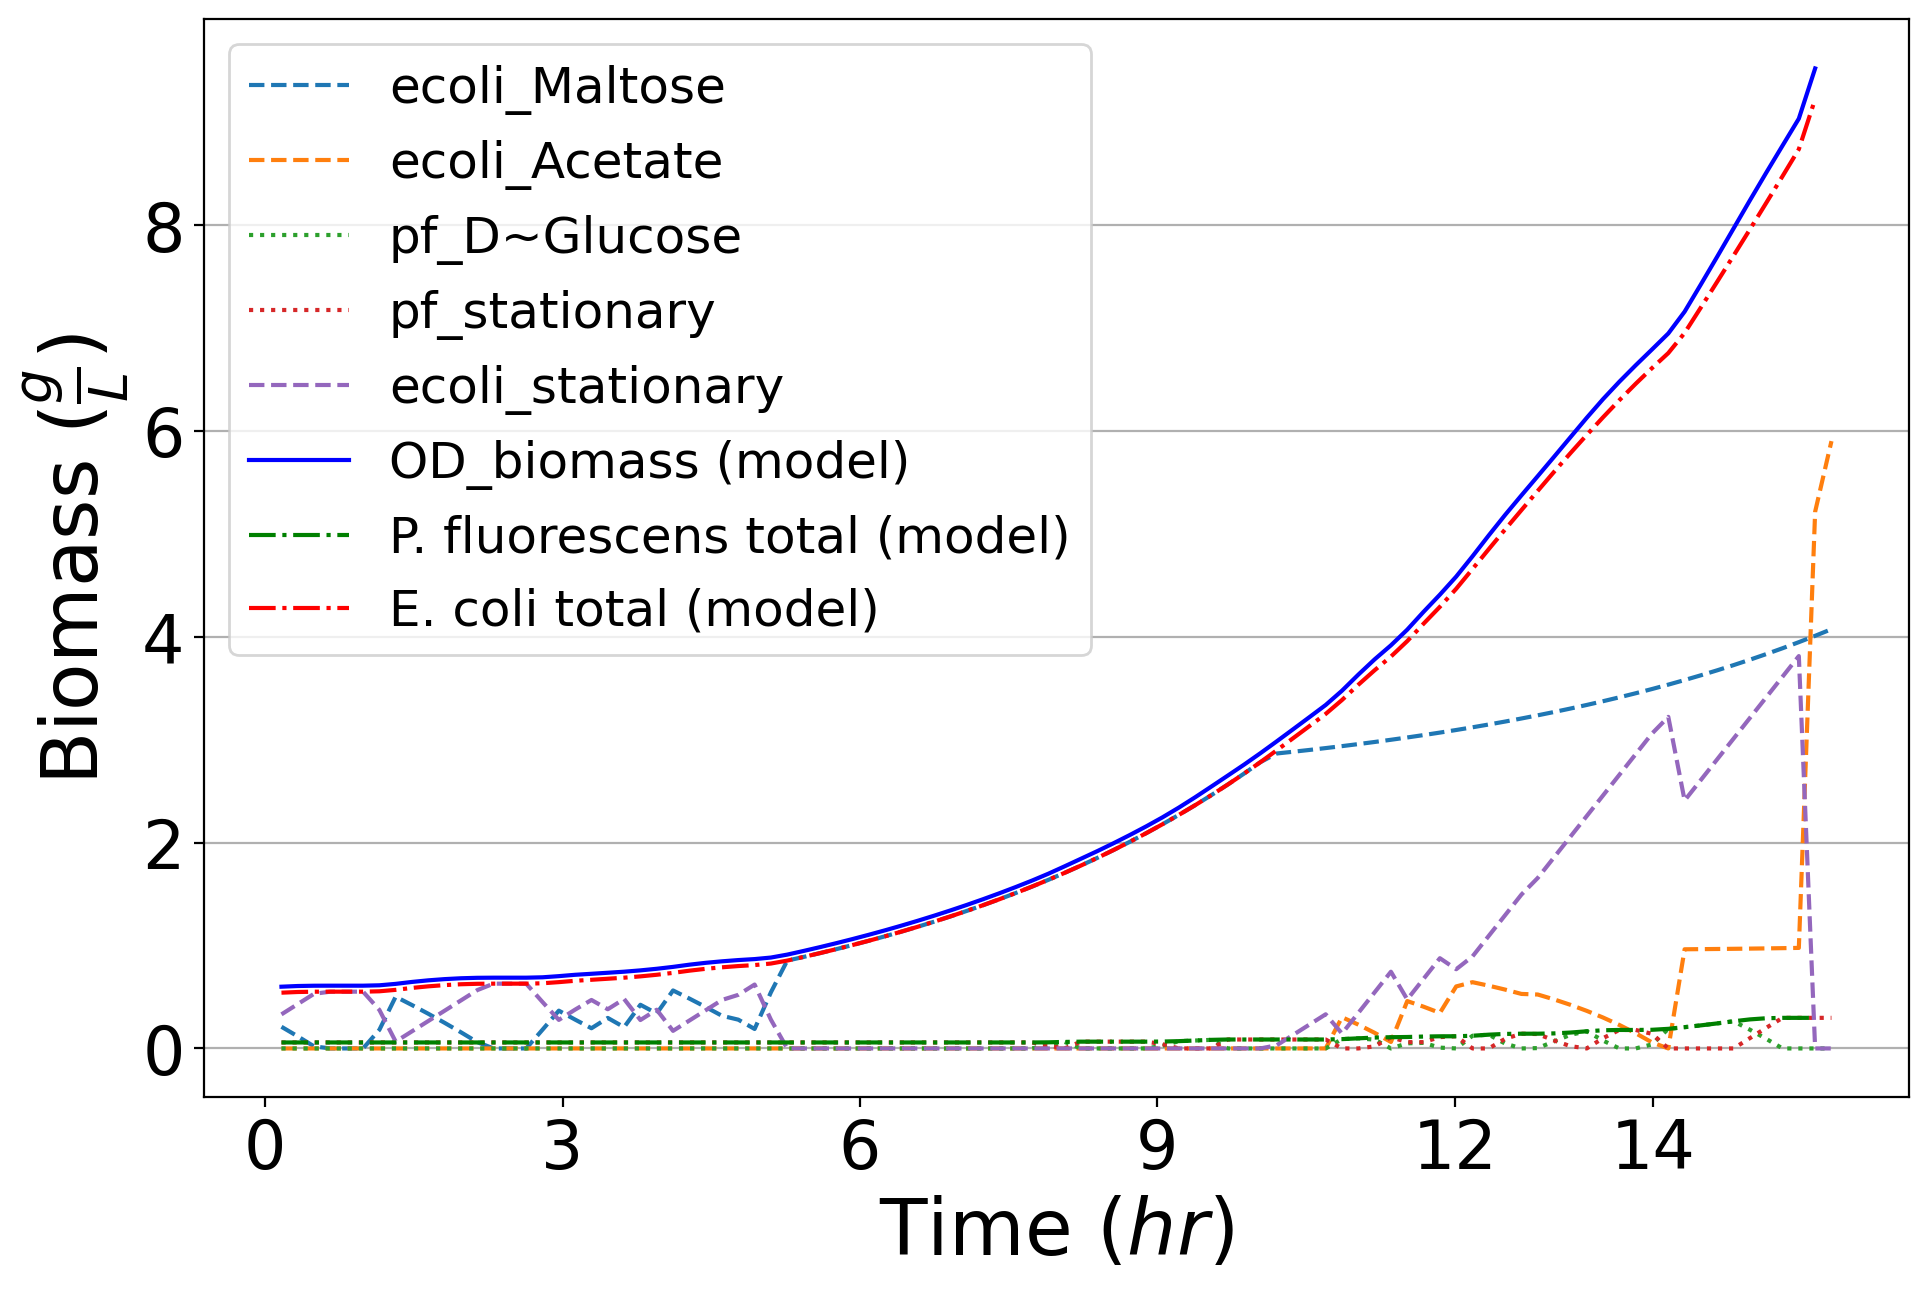

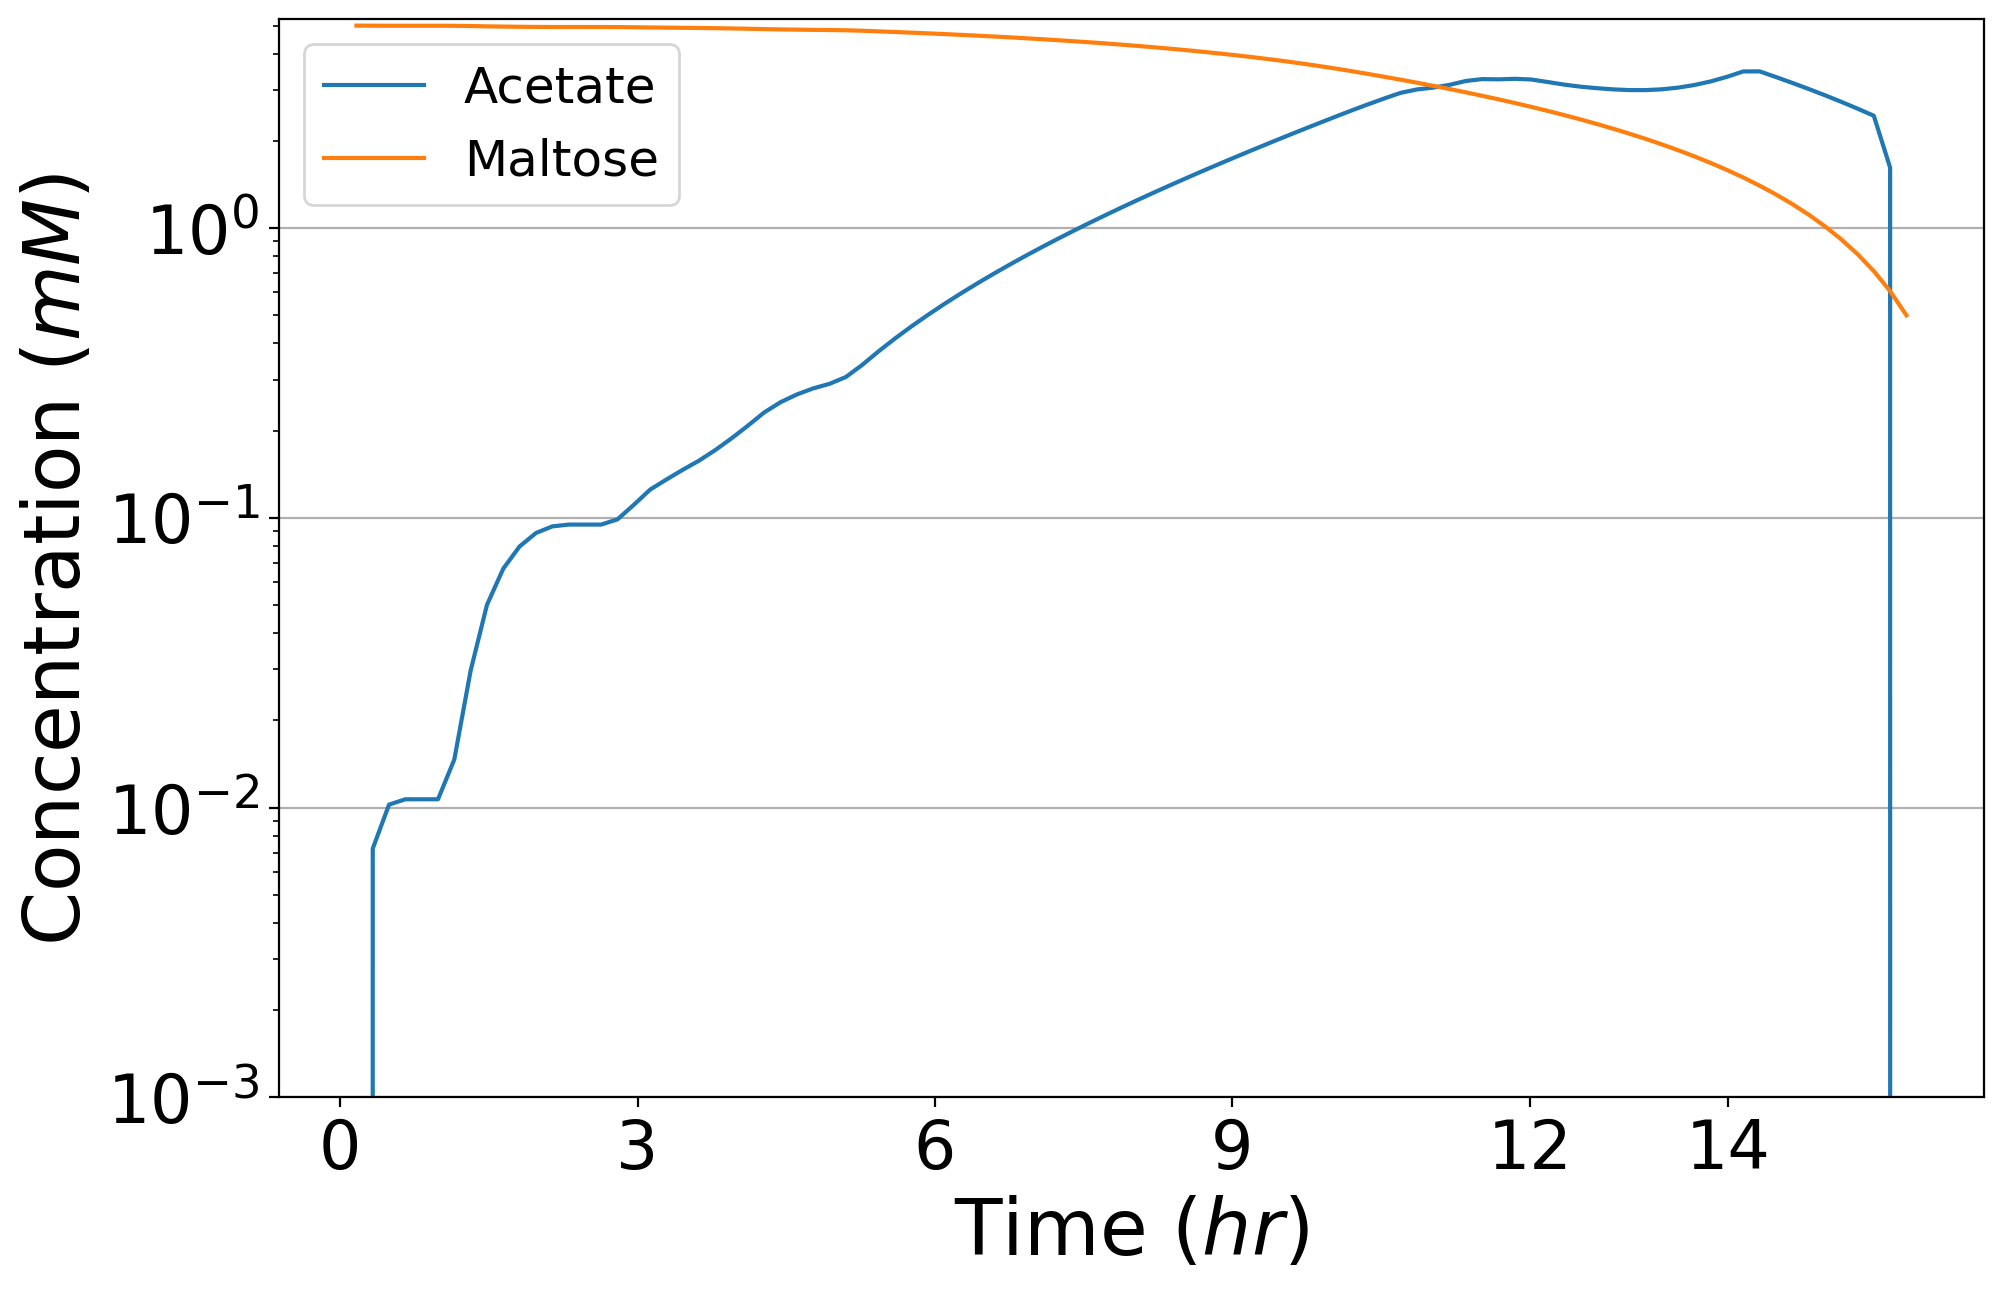

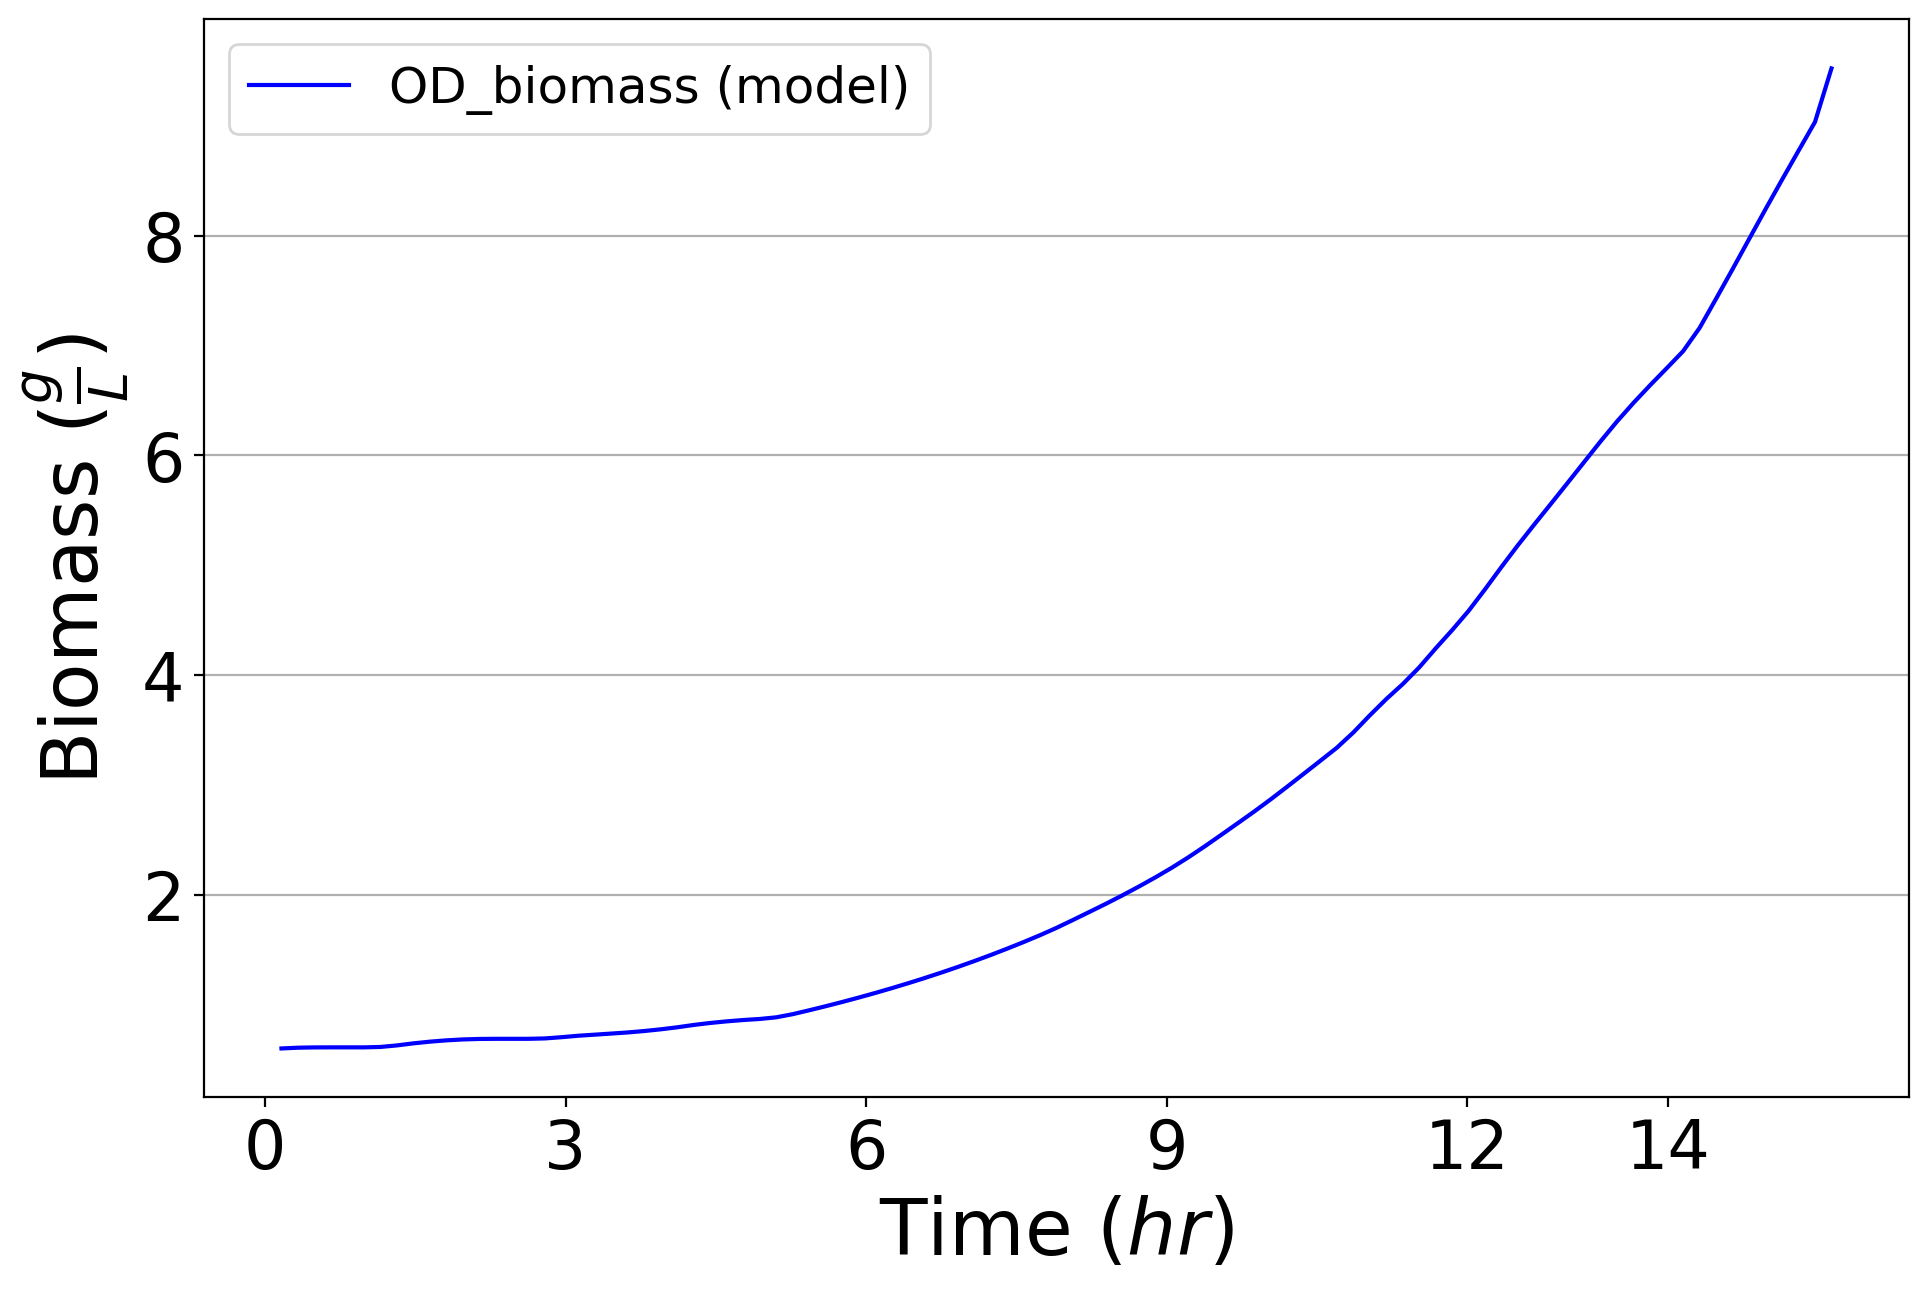

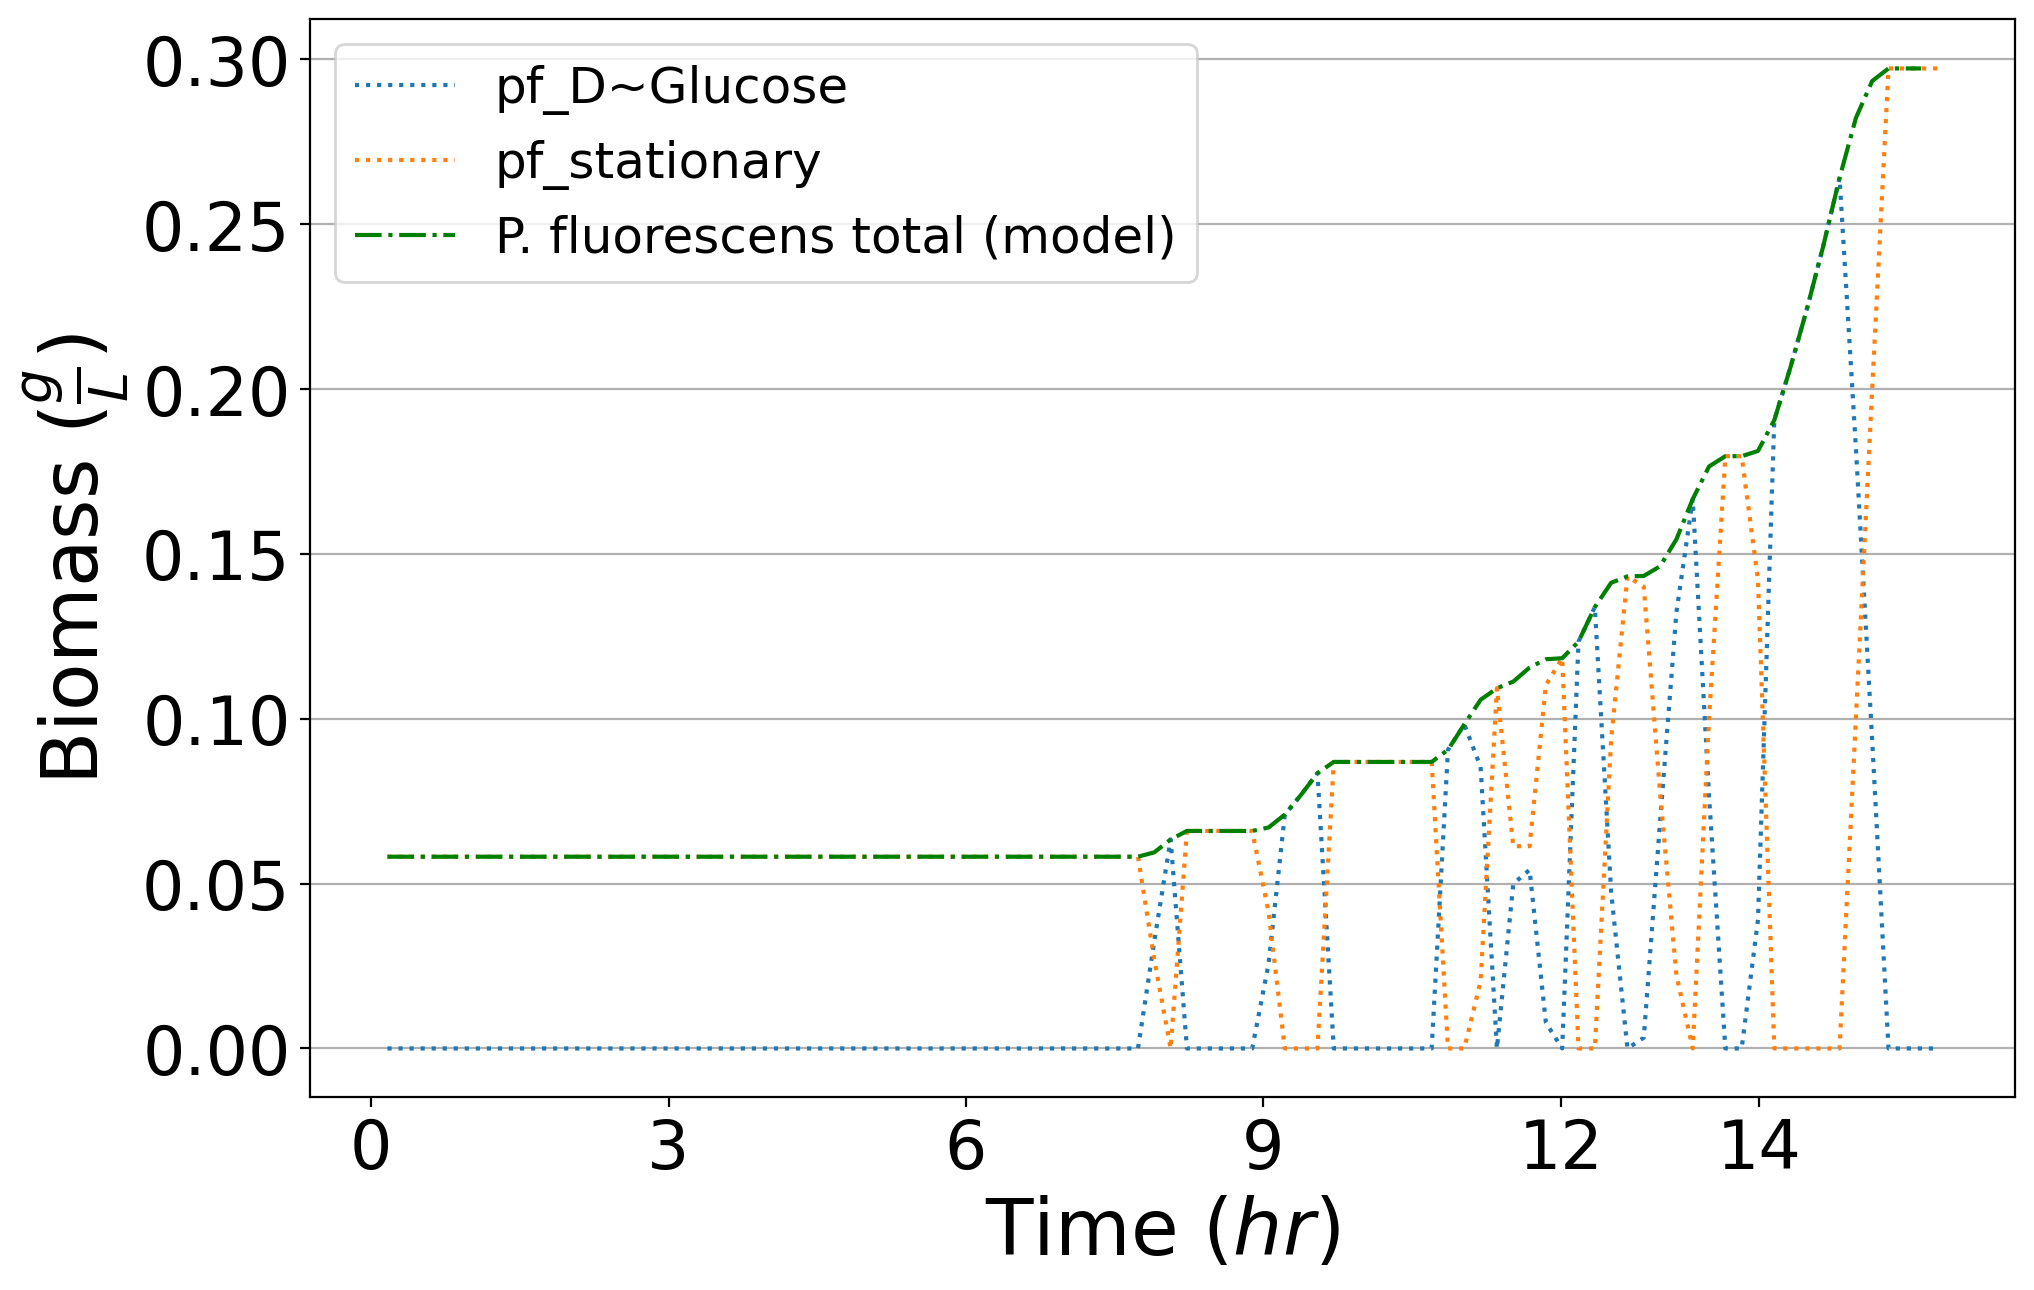

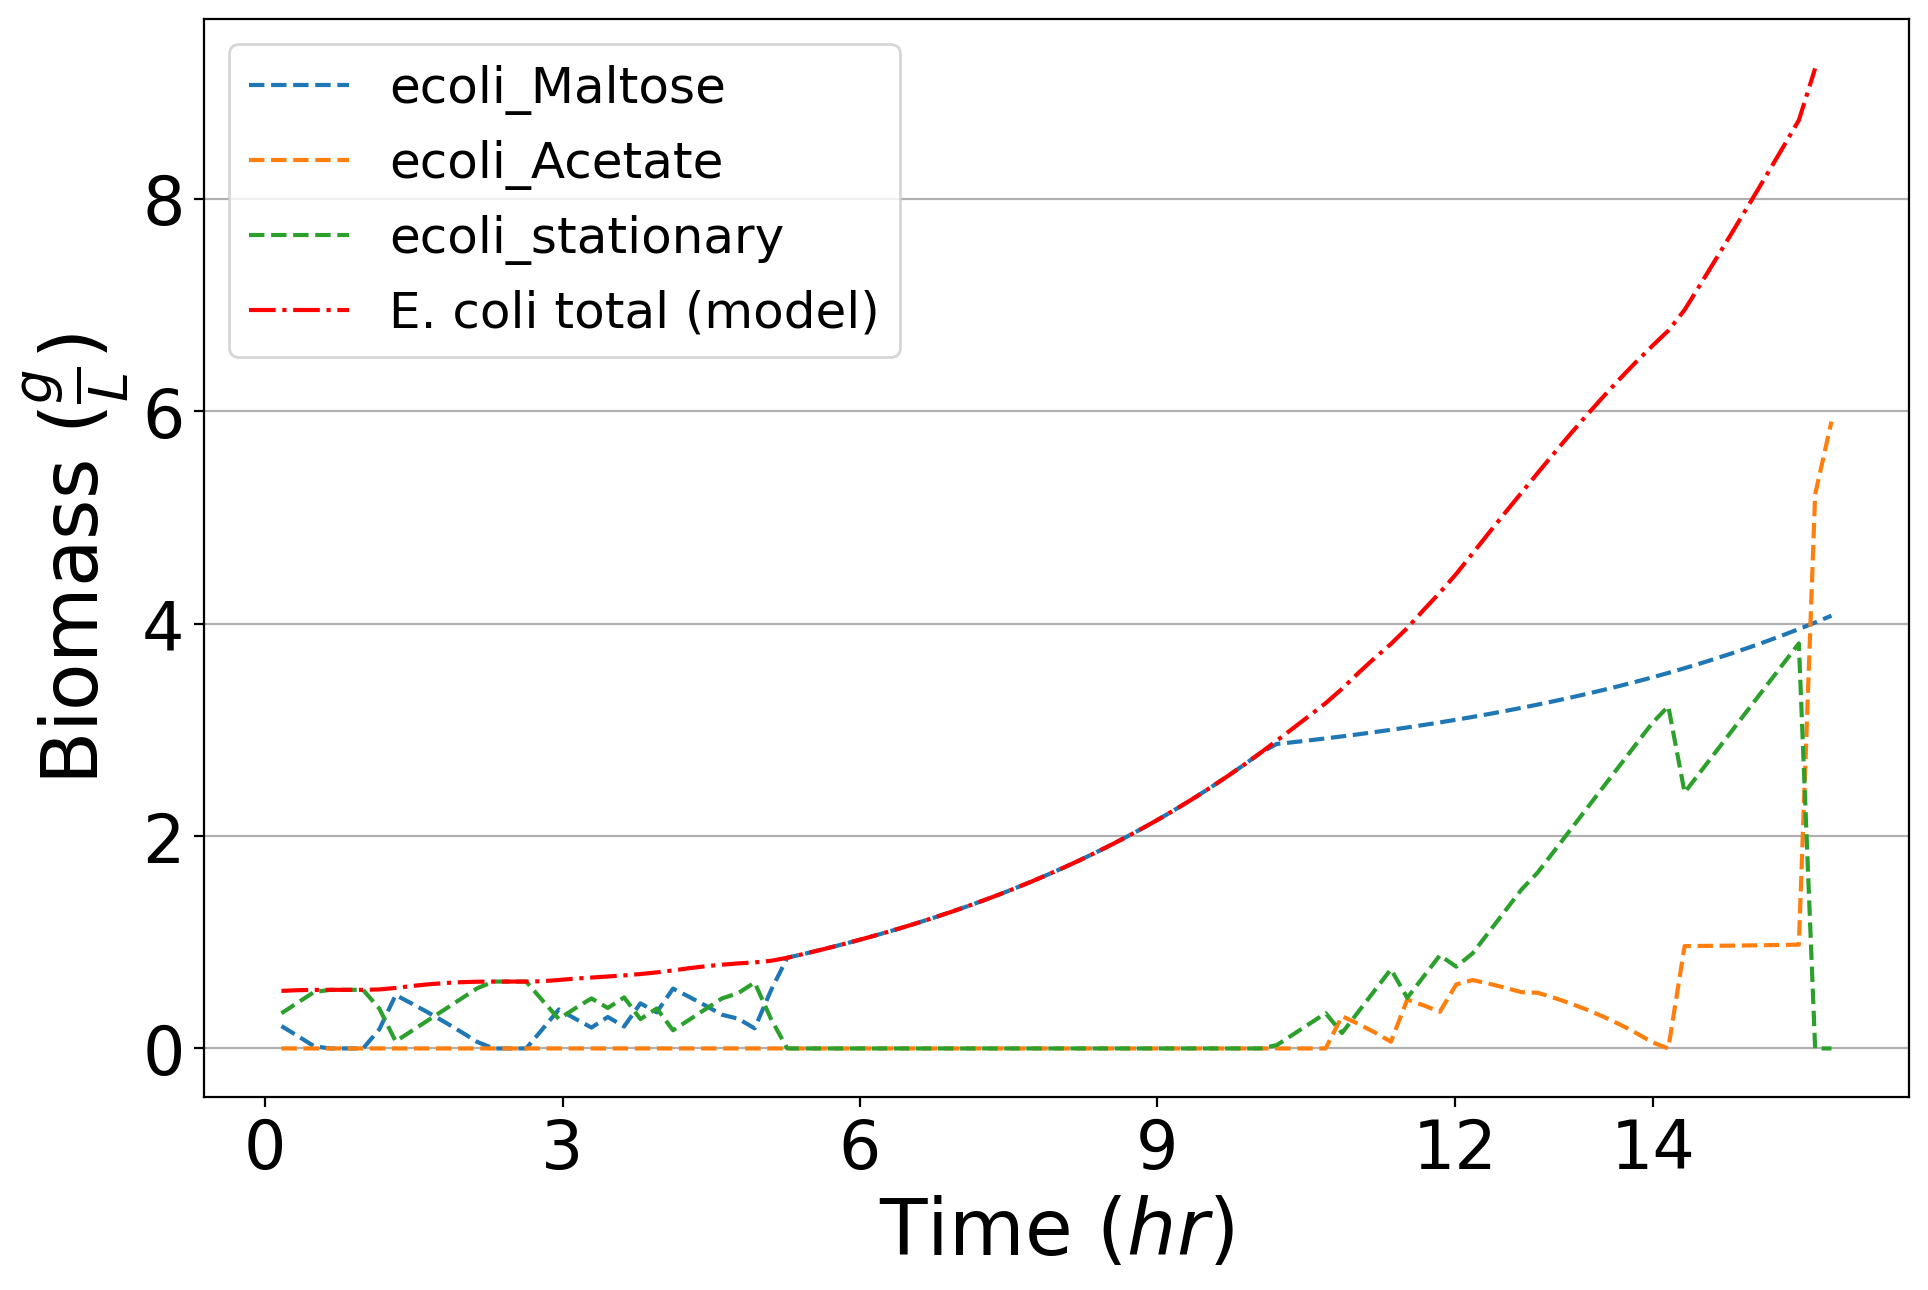

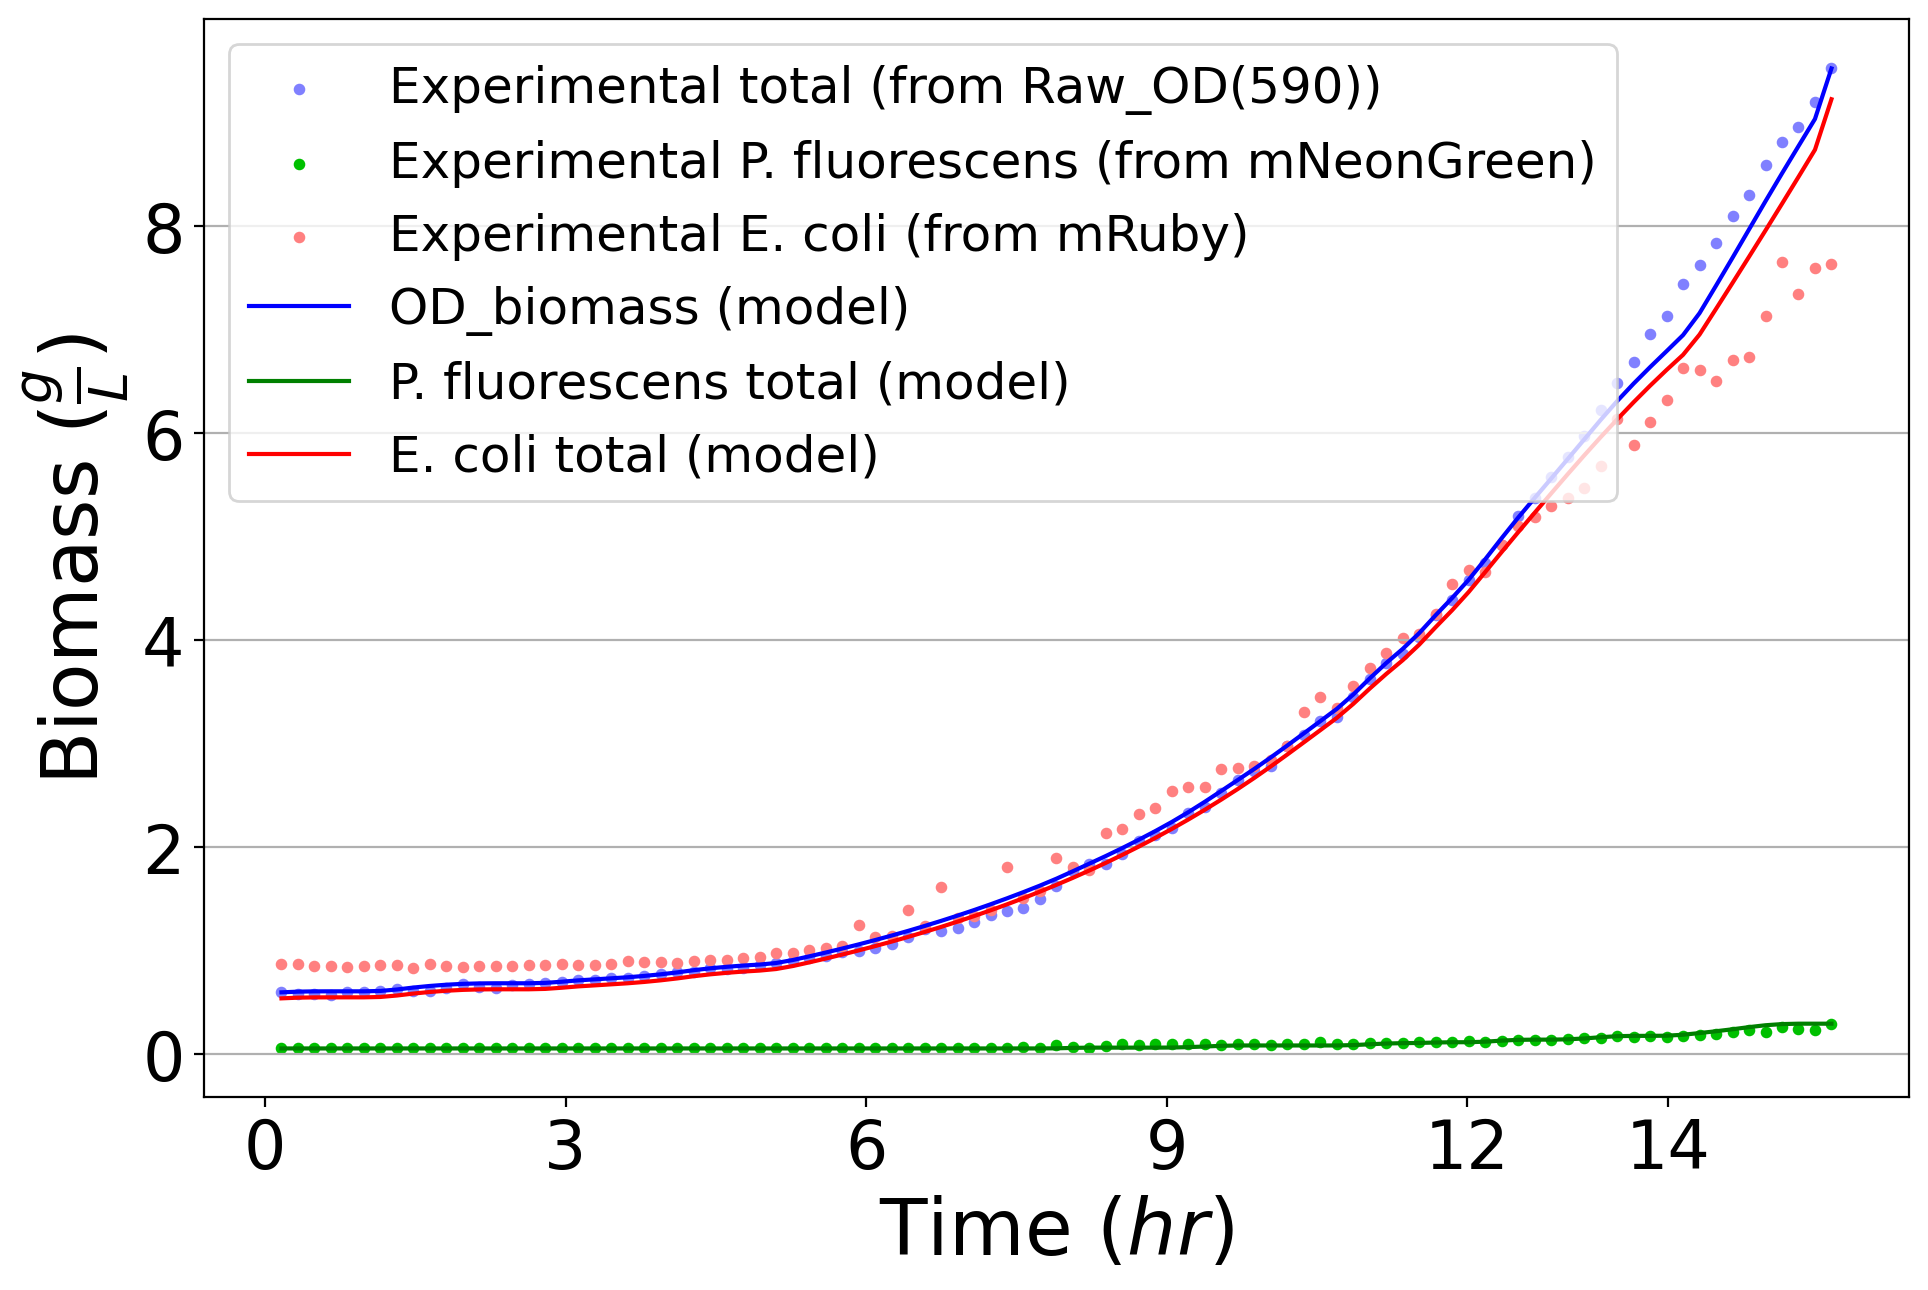

In [14]:
%%time 

maltose_co.compute(update_graphs("G6"), None, None, True, "test_primals_simple.json")

# new ModelSEEDpy API

### Load base parameters

In [2]:
# import the models
from cobra.io import load_json_model
ecoli = load_json_model("ecoli.json")
pf = load_json_model("pf.json")
# print(ecoli.optimize())
# print(pf.optimize())
    
# load peripheral packages
import warnings
warnings.filterwarnings(action='once')
from pandas import set_option
set_option("display.max_rows", None)
from time import process_time

# Define the standard graphs from each simulation
graphs_list = [
    {
        'trial':'G48',
        "phenotype": '*',
        'content': 'biomass',
        'experimental_data': False,
        # "parsed":True
    },
    {
        'trial':'G48',
        'content': "conc",
    },
    {
        'trial':'G48',
        "phenotype": '*',
        'content': 'biomass',
        "parsed": True
    },
    {
        'trial':'G48',
        'content': 'total_biomass',
        'experimental_data': True
    }
]

def update_graphs(trial):
    graphs = graphs_list.copy()
    for graph in graphs:
        graph["trial"] = trial
    return graphs

species_abundances = {
    1:{"ecoli":0, "pf":1},
    2:{"ecoli":1, "pf":50},
    3:{"ecoli":1, "pf":20},
    4:{"ecoli":1, "pf":10},
    5:{"ecoli":1, "pf":3},
    6:{"ecoli":1, "pf":1},
    7:{"ecoli":3, "pf":1},
    8:{"ecoli":10, "pf":1},
    9:{"ecoli":20, "pf":1},
    10:{"ecoli":1, "pf":0},
    11:{"ecoli":0, "pf":0}
}
carbon_conc_series = {'rows': {
    'cpd00136': {'B':0, 'C': 0, 'D': 1, 'E': 1, 'F': 4, 'G': 4},
    'cpd00179': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
    # 'cpd00100': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
}}
species_identities_rows = {
    1:{"ecoli":"mRuby"},
    2:{"ecoli":"ACS"},
    3:{"ecoli":"mRuby"},
    4:{"ecoli":"ACS"},
    5:{"ecoli":"mRuby"},
    6:{"ecoli":"ACS"}
}

### Maltose E.coli

In [4]:
from modelseedpy import MSCommPhitting
# %run ../../../ModelSEED/ModelSEEDpy/modelseedpy/community/mscommphitting.py

test_com = MSCommPhitting('../../../ModelSEED/ModelSEEDDatabase',
                           community_members = {
                                ecoli: {
                                    'name': 'ecoli', 
                                    'phenotypes': {
                                        'Maltose': {"consumed":["cpd00179"],
                                                 "excreted":["cpd00029"]}, #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                                        'Acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                                        }
                                },
                                pf: {
                                    'name': 'pf',
                                    'phenotypes': {
                                        'Acetate': {"consumed":["cpd00029"]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                                        '4-Hydroxybenzoate': {"consumed":["cpd00136"]}, # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                                        # 'Glycerol': {"consumed":["cpd00100"],
                                        #          "excreted":["cpd00266"]}, #kbase_api.get_from_ws('93465/13/1'), 
                                        }
                                }
                            },
                            data_paths = {'path':"data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx", 'Raw OD(590)':'OD', 'mNeonGreen':'pf', 'mRuby':'ecoli'},
                            species_abundances = species_abundances,
                            carbon_conc = carbon_conc_series,
                            ignore_trials = {'rows': ['C', 'D', 'E', 'F', 'G'], 'columns': [1,2,3,4,5,6,7,8,9,10,12]},
                            species_identities_rows = species_identities_rows)

test_com.fit(parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 5e-3},
             mets_to_track = ["cpd00179","cpd00029"],
             rel_final_conc = {"cpd00179":0.1},
             zero_start = ["cpd00029"],
             abs_final_conc = {"cpd00029":0}, # metabolomics data
             graphs=update_graphs("G10"),
             export_zip_name = 'maltose_ecoli.zip',
             export_lp = "maltose_ecoli.lp",
             primals_export_path="maltose_ecoli_primals.json")


 GCF_000005845.2.RAST.mdl
EX_cpd00179_e0
EX_cpd00029_e0

 GCF_001612705.1.RAST.mdl
EX_cpd00029_e0
EX_cpd00136_e0
The ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B12', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12'] trials were dropped from the OD measurements per the ignore_trials parameter.
The [81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 

ecoli_Maltose  ecoli_Acetate    pf_Acetate  \
rxn                                                          
EX_cpd00001_e0       0.000000   4.544367e+00  4.533296e+00   
EX_cpd00007_e0     -22.000910  -2.035609e+00 -2.025521e+00   
EX_cpd00009_e0      -0.076254  -7.625410e-02 -7.625410e-02   
EX_cpd00011_e0      28.376856   2.388151e+00  2.377641e+00   
EX_cpd00013_e0      -0.861167  -8.611666e-01 -8.611666e-01   
EX_cpd00029_e0     100.000000  -3.069851e+00 -3.063614e+00   
EX_cpd00030_e0      -0.000281  -2.806159e-04 -2.806159e-04   
EX_cpd00034_e0      -0.000281  -2.806159e-04 -2.806159e-04   
EX_cpd00048_e0      -0.240125  -2.263972e-02 -2.263972e-02   
EX_cpd00058_e0      -0.000281  -2.806159e-04 -2.806159e-04   
EX_cpd00063_e0      -0.000281  -2.806159e-04 -2.806159e-04   
EX_cpd00067_e0     100.000000  -2.417395e+00 -2.411719e+00   
EX_cpd00099_e0      -0.000281  -2.806159e-04 -2.806159e-04   
EX_cpd00116_e0       0.000281   2.806159e-04  2.806159e-04   
EX_cpd00136_e0       0.000000   0.000000e+00  0.000000e+00   
EX_cpd00149_e0      -0.000281  -2.806159e-04 -2.806159e-04   
EX_cpd00179_e0     -19.356205   0.000000e+00  0.000000e+00   
EX_cpd00205_e0      -0.000281  -2.806159e-04 -2.806159e-04   
EX_cpd00239_e0       0.217486   0.000000e+00  0.000000e+00   
EX_cpd00254_e0      -0.000281  -2.806159e-04 -2.806159e-04   
EX_cpd00314_e0       0.024341   0.000000e+00  0.000000e+00   
EX_cpd00971_e0       0.000000   0.000000e+00  1.715580e-16   
EX_cpd10515_e0      -0.001122  -1.122464e-03 -1.122464e-03   
EX_cpd10516_e0       0.000000  -3.082411e-13  2.534065e-13   
EX_cpd11640_e0      11.152527   0.000000e+00  0.000000e+00   
EX_cpd15378_e0       0.000281   2.806159e-04  0.000000e+00   
bio                  0.100000   1.000000e-01  1.000000e-01   

                pf_4~Hydroxybenzoate  
rxn                                   
EX_cpd00001_e0              2.449417  
EX_cpd00007_e0             -5.333032  
EX_cpd00009_e0             -0.076254  
EX_cpd00011_e0              5.685222  
EX_cpd00013_e0             -0.861167  
EX_cpd00029_e0              0.000000  
EX_cpd00030_e0             -0.000281  
EX_cpd00034_e0             -0.000281  
EX_cpd00048_e0             -0.022640  
EX_cpd00058_e0             -0.000281  
EX_cpd00063_e0             -0.000281  
EX_cpd00067_e0             -2.043484  
EX_cpd00099_e0             -0.000281  
EX_cpd00116_e0              0.000281  
EX_cpd00136_e0             -1.347830  
EX_cpd00149_e0             -0.000281  
EX_cpd00179_e0              0.000000  
EX_cpd00205_e0             -0.000281  
EX_cpd00239_e0              0.000000  
EX_cpd00254_e0             -0.000281  
EX_cpd00314_e0              0.000000  
EX_cpd00971_e0              0.000000  
EX_cpd10515_e0             -0.000842  
EX_cpd10516_e0             -0.000281  
EX_cpd11640_e0              0.000000  
EX_cpd15378_e0              0.000000  
bio                         0.100000

Done with concentrations and biomass loops: 0.0296875 min
Done with DCC loop: 0.00078125 min
Done with the DBC & diffc loop: 0.002864583333333333 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.08984375 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'maltose_ecoli.lp'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.05078125 min
starting optimization


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\modelseedpy\community\mscommphitting.py:120: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)


FeasibilityError: The solution is sub-optimal, with a(n) infeasible status.

### Adding a missing reaction via the ModelSEED Database

In [1]:
from modelseedpy.biochem import from_local

msdb = from_local('../../../ModelSEED/ModelSEEDDatabase')

In [2]:
from cobra import Reaction, Metabolite
# rxn01727 = msdb.reactions.get_by_id("rxn01727")
# rxn01727.id = "rxn01727_c0"

from cobra.io import load_json_model
pf = load_json_model("pf.json")

# from modelseedpy import MSModelUtil
%run "../../../ModelSEED/ModelSEEDpy/modelseedpy/core/msmodelutl"

msutil = MSModelUtil(pf)
msutil.add_ms_reaction({
    "rxn01727": "c0", 
    "rxn02469": "c0", 
    "rxn00032": "c0", 
    "rxn01867": "c0", 
    "rxn08258": "c0", 
    "rxn01407": "c0"
}, msdb_object=msdb)

# BioCyc IDed reactions
cpd00870_c0 = Metabolite(
    'cpd00870_c0',
    formula = 'C7H15NO2',
    name = 'gamma-butyrobetaine',
    compartment = 'c')
cpd15412_c0 = Metabolite(
    'cpd15412_c0',
    formula = 'C28H46N8O17P3S',
    name = 'gamma-butyrobetainyl-CoA',
    compartment = 'c')
msutil.model.add_metabolites([cpd00870_c0, cpd15412_c0])

RXN_22878 = Reaction(id = "RXN_22878")
RXN_22878.add_metabolites({
    msutil.model.metabolites.cpd00870_c0: -1,
    msutil.model.metabolites.cpd00022_c0: -1,
    msutil.model.metabolites.cpd15412_c0: 1,
    msutil.model.metabolites.cpd00029_c0: 1
})
RXN_22886 = Reaction(id = "RXN_22886")
RXN_22886.add_metabolites({
    msutil.model.metabolites.cpd15440_c0: -1,
    msutil.model.metabolites.cpd00001_c0: -1,
    msutil.model.metabolites.cpd00010_c0: 1,
    msutil.model.metabolites.cpd00266_c0: 1
})

msutil.model.add_reactions([RXN_22886, RXN_22878])


# also to add < "RXN-22878", "RXN-22886" > through the custom code that Ashley constructed for these reactions and their metabolites

# cpd00870_c0 = Metabolite(
#     'cpd00870_c0',
#     formula = 'C7H15NO2',
#     name = 'gamma-butyrobetaine',
#     compartment = 'c')
# pf.add_metabolites([cpd00870_c0])

# rxn01727 = Reaction(id = "rxn01727")
# rxn01727.add_metabolites({
#     pf.metabolites.get_by_id("cpd00007_c0"): -1, 
#     pf.metabolites.get_by_id("cpd00024_c0"): -1, 
#     pf.metabolites.get_by_id("cpd00870_c0"): -1, 
#     pf.metabolites.get_by_id("cpd00011_c0"): 1,
#     pf.metabolites.get_by_id("cpd00036_c0"): 1,
#     pf.metabolites.get_by_id("cpd00266_c0"): 1
# })
# pf.add_reactions([rxn01727])

The rxn01727_c0 reaction is defined.
The rxn02469_c0 reaction is defined.
The rxn00032_c0 reaction is defined.
The rxn01867_c0 reaction is defined.
The rxn08258_c0 reaction is defined.
The rxn01407_c0 reaction is defined.
6 reactions and 19 metabolites were added to the model.


In [3]:
print(msutil.model.reactions.rxn01727_c0)
print(msutil.model.reactions.rxn02469_c0 )
print(msutil.model.reactions.rxn00032_c0 )
print(msutil.model.reactions.rxn01867_c0 )
print(msutil.model.reactions.rxn08258_c0 )
print(msutil.model.reactions.RXN_22878)
print(msutil.model.reactions.RXN_22886)

rxn01727_c0: cpd00007_0_c0 + cpd00024_0_c0 + cpd00870_0_c0 --> cpd00011_0_c0 + cpd00036_0_c0 + cpd00266_0_c0
rxn02469_c0: cpd00007_0_c0 + cpd00024_0_c0 + cpd02374_0_c0 --> cpd00011_0_c0 + cpd00036_0_c0 + cpd00923_0_c0
rxn00032_c0: cpd00007_0_c0 + 2 cpd00098_0_c0 --> 2 cpd00001_0_c0 + 2 cpd00447_0_c0
rxn01867_c0: cpd00001_c0 + cpd00003_c0 + cpd00447_c0 --> cpd00004_c0 + 2 cpd00067_c0 + cpd00540_c0
rxn08258_c0: cpd15440_c0 <=> cpd00001_c0 + cpd15441_c0
RXN_22878: cpd00022_c0 + cpd00870_c0 --> cpd00029_c0 + cpd15412_c0
RXN_22886: cpd00001_c0 + cpd15440_c0 --> cpd00010_c0 + cpd00266_c0


### Glycreol phenotype

In [4]:
# import the models
# from cobra.io import load_json_model
# ecoli = load_json_model("ecoli.json")
# pf = load_json_model("pf.json")
# print(ecoli.optimize())
# print(pf.optimize())
    
# load peripheral packages
import warnings
warnings.filterwarnings(action='once')
from pandas import set_option
set_option("display.max_rows", None)
from time import process_time

# Define the standard graphs from each simulation
graphs_list = [
    {
        'trial':'G48',
        "phenotype": '*',
        'content': 'biomass',
        'experimental_data': False,
        # "parsed":True
    },
    {
        'trial':'G48',
        'content': "conc",
    },
    {
        'trial':'G48',
        "phenotype": '*',
        'content': 'biomass',
        "parsed": True
    },
    {
        'trial':'G48',
        'content': 'total_biomass',
        'experimental_data': True
    }
]

def update_graphs(trial):
    graphs = graphs_list.copy()
    for graph in graphs:
        graph["trial"] = trial
    return graphs

species_abundances = {
    1:{"ecoli":0, "pf":1},
    2:{"ecoli":1, "pf":50},
    3:{"ecoli":1, "pf":20},
    4:{"ecoli":1, "pf":10},
    5:{"ecoli":1, "pf":3},
    6:{"ecoli":1, "pf":1},
    7:{"ecoli":3, "pf":1},
    8:{"ecoli":10, "pf":1},
    9:{"ecoli":20, "pf":1},
    10:{"ecoli":1, "pf":0},
    11:{"ecoli":0, "pf":0}
}
carbon_conc_series = {'rows': {
    'cpd00136': {'B':0, 'C': 0, 'D': 1, 'E': 1, 'F': 4, 'G': 4},
    'cpd00179': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
    # 'cpd00100': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
}}
species_identities_rows = {
    1:{"ecoli":"mRuby"},
    2:{"ecoli":"ACS"},
    3:{"ecoli":"mRuby"},
    4:{"ecoli":"ACS"},
    5:{"ecoli":"mRuby"},
    6:{"ecoli":"ACS"}
}

In [5]:
from modelseedpy import MSCommPhitting
# %run ../../../ModelSEED/ModelSEEDpy/modelseedpy/community/mscommphitting.py
ecoli = load_json_model("ecoli.json")

carbon_conc_series = {'rows': {
    'cpd00136': {'B':0, 'C': 0, 'D': 1, 'E': 1, 'F': 4, 'G': 4},
    'cpd00179': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
    'cpd00100': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
}}

test_com = MSCommPhitting('../../../ModelSEED/ModelSEEDDatabase',
                           community_members = {
                                ecoli: {
                                    'name': 'ecoli', 
                                    'phenotypes': {
                                        'Maltose': {"consumed":["cpd00179"],
                                                 "excreted":["cpd00029"]}, #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                                        'Acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                                        }
                                },
                                msutil.model: {
                                    'name': 'pf',
                                    'phenotypes': {
                                        'Acetate': {"consumed":["cpd00029"]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                                        '4-Hydroxybenzoate': {"consumed":["cpd00136"]}, # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                                        'Glycerol': {"consumed":["cpd00100"],
                                                 "excreted":["cpd00266"]}, #kbase_api.get_from_ws('93465/13/1'), 
                                        }
                                }
                            },
                            data_paths = {'path':"data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx", 'Raw OD(590)':'OD', 'mNeonGreen':'pf', 'mRuby':'ecoli'},
                            species_abundances = species_abundances,
                            carbon_conc = carbon_conc_series,
                            ignore_trials = {'rows': ['C', 'D', 'E', 'F', 'G'], 'columns': [1,2,3,4,5,6,8,9,10,11,12]},
                            species_identities_rows = species_identities_rows)

test_com.fit(parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 5e-3},
             mets_to_track = ["cpd00100","cpd00029", "cpd00266"],
             rel_final_conc = {"cpd00100":0.1},
             zero_start = ["cpd00029", "cpd00266"],
             abs_final_conc = {"cpd00029":0}, # metabolomics data
             graphs=update_graphs("G6"),
             export_zip_name = 'glycerol_co.zip',
             export_lp = "glycerol_coculture_simple.lp",
             primals_export_path="glycerol_primals_simple.json")


 GCF_000005845.2.RAST.mdl
EX_cpd00179_e0
EX_cpd00029_e0

 GCF_001612705.1.RAST.mdl
EX_cpd00029_e0
EX_cpd00136_e0


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


EX_cpd00100_e0
The ['B2', 'B3', 'B4', 'B5', 'B6', 'B8', 'B9', 'B10', 'B11', 'B12', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12'] trials were dropped from the OD measurements per the ignore_trials parameter.
The [97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166] timesteps (with [1.12550559 1.12537038 1.12105398 1.11597471 1.11273534 1.12893569
 1.13334937 1.13336892 1.13261206 1.13469994 1.13451431 1.1

ecoli_Maltose  ecoli_Acetate    pf_Acetate  \
rxn                                                          
EX_cpd00001_e0   1.618125e+01   4.544367e+01  4.533296e+01   
EX_cpd00007_e0  -6.452599e+00  -2.035609e+01 -2.025521e+01   
EX_cpd00009_e0  -7.625410e-01  -7.625410e-01 -7.625410e-01   
EX_cpd00011_e0   1.073081e+00   2.388151e+01  2.377641e+01   
EX_cpd00013_e0  -8.611666e+00  -8.611666e+00 -8.611666e+00   
EX_cpd00029_e0   1.051566e+01  -3.069851e+01 -3.063614e+01   
EX_cpd00030_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00034_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00047_e0   1.781127e+01   0.000000e+00  0.000000e+00   
EX_cpd00048_e0  -2.263972e-01  -2.263972e-01 -2.263972e-01   
EX_cpd00058_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00063_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00067_e0   3.485430e+01  -2.417395e+01 -2.411719e+01   
EX_cpd00099_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00100_e0   0.000000e+00   0.000000e+00  0.000000e+00   
EX_cpd00116_e0   2.806159e-03   2.806159e-03  2.806159e-03   
EX_cpd00136_e0   0.000000e+00   0.000000e+00  0.000000e+00   
EX_cpd00142_e0  -2.155574e-12   0.000000e+00  0.000000e+00   
EX_cpd00149_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00179_e0  -6.452599e+00   0.000000e+00  0.000000e+00   
EX_cpd00205_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00254_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00609_e0   1.080143e-15   0.000000e+00  0.000000e+00   
EX_cpd00751_e0   5.380949e-29   0.000000e+00  0.000000e+00   
EX_cpd01914_e0   1.315265e-12   0.000000e+00  0.000000e+00   
EX_cpd03048_e0   6.972492e-13   0.000000e+00  0.000000e+00   
EX_cpd10515_e0  -8.418477e-03  -1.122464e-02 -1.122464e-02   
EX_cpd10516_e0  -2.806159e-03  -1.359101e-11 -3.420734e-13   
EX_cpd15378_e0   2.806159e-03   2.806159e-03  0.000000e+00   
bio              1.000000e+00   1.000000e+00  1.000000e+00   

                pf_4~Hydroxybenzoate  pf_Glycerol  
rxn                                                
EX_cpd00001_e0          2.449548e+01    44.826581  
EX_cpd00007_e0         -5.333079e+01   -12.153085  
EX_cpd00009_e0         -7.625410e-01    -0.762541  
EX_cpd00011_e0          5.685199e+01     8.078550  
EX_cpd00013_e0         -8.611666e+00    -8.611666  
EX_cpd00029_e0          0.000000e+00     0.000000  
EX_cpd00030_e0         -2.806159e-03    -0.002806  
EX_cpd00034_e0         -2.806159e-03    -0.002806  
EX_cpd00047_e0          0.000000e+00     0.000000  
EX_cpd00048_e0         -2.263972e-01    -0.226397  
EX_cpd00058_e0         -2.806159e-03    -0.002806  
EX_cpd00063_e0         -2.806159e-03    -0.002806  
EX_cpd00067_e0         -2.043758e+01     6.518956  
EX_cpd00099_e0         -2.806159e-03    -0.002806  
EX_cpd00100_e0          0.000000e+00   -15.191477  
EX_cpd00116_e0          2.806159e-03     0.002806  
EX_cpd00136_e0         -1.347827e+01     0.000000  
EX_cpd00142_e0          0.000000e+00     0.000000  
EX_cpd00149_e0         -2.806159e-03    -0.002806  
EX_cpd00179_e0          0.000000e+00     0.000000  
EX_cpd00205_e0         -2.806159e-03    -0.002806  
EX_cpd00254_e0         -2.806159e-03    -0.002806  
EX_cpd00609_e0          0.000000e+00     0.000000  
EX_cpd00751_e0          0.000000e+00     0.000000  
EX_cpd01914_e0          0.000000e+00     0.000000  
EX_cpd03048_e0          0.000000e+00     0.000000  
EX_cpd10515_e0         -1.122464e-02    -0.011225  
EX_cpd10516_e0          8.828545e-12     0.000000  
EX_cpd15378_e0          0.000000e+00     0.000000  
bio                     1.000000e+00     1.000000

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\modelseedpy\community\mscommphitting.py:72: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)


KeyError: 'EX_cpd00266_e0'